In [7]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
from bold_dementia.data.study import balance_control
from bold_dementia.connectivity import plot_matrix, Atlas, fast_hist, reshape_pvalues

import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from formulaic import model_matrix
from scipy.stats import ttest_ind

ATLAS = "msdl"
SOFT = True
pd.options.mode.copy_on_write = True

In [8]:
matrices_path = Path(
    f"{config['output_dir']}/connectivity/atlas-{ATLAS}_balanced-sex-age_z-transformed_strategy-high_pass-motion-wm_csf"
)
print(f"Fetching data in {matrices_path}")
# TODO Allow longitudinal and add subject_id to random effects
# TODO Intracranial volume
AD_matrices = joblib.load(matrices_path / "AD.joblib")
control_matrices = joblib.load(matrices_path / "control.joblib")
atlas = Atlas.from_name(ATLAS, SOFT)

Fetching data in /homes_unix/jlegrand/data/Memento/output/connectivity/atlas-msdl_balanced-sex-age_z-transformed_strategy-high_pass-motion-wm_csf


In [9]:
def mat_to_vec(mat):
    n = len(mat)
    tril_i = np.tril_indices(n, k=-1)
    flat_mat = mat[tril_i].ravel()
    return flat_mat

def z_transform_mat(mat):
    flat_mat = mat_to_vec(mat)
    z_transformed = np.arctanh(flat_mat)
    return reshape_pvalues(z_transformed)


In [10]:
AD_matrices_z = np.array(tuple(map(z_transform_mat, AD_matrices)))
control_matrices_z = np.array(tuple(map(z_transform_mat, control_matrices)))

In [11]:
def z_transform_to_vec(mat):
    vec = mat_to_vec(mat)
    return np.arctanh(vec)

AD_vec = np.array([z_transform_to_vec(mat) for mat in AD_matrices])
control_vec = np.array([z_transform_to_vec(mat) for mat in control_matrices])

flatcov = ttest_ind(
    control_vec,
    AD_vec,
    alternative="two-sided"
)

In [12]:
# TODO Check order consistency in scripts before
AD_df = pd.read_csv(matrices_path / "balanced_AD.csv", index_col=0)
control_df = pd.read_csv(matrices_path / "balanced_control.csv", index_col=0)
df = pd.concat((AD_df, control_df))

In [37]:
# fc shape is (n_subjects, n_connectivity_coeffs)
fc = np.vstack((AD_vec, control_vec))
fc = pd.DataFrame(fc, columns=[f"ROI_{i}" for i in range(fc.shape[1])])
df["AD"] = np.where(df.scan_to_onset < 0, 1, 0)
df = pd.concat([df.reset_index(drop=True), fc], axis=1, join="inner")
cleaned_df = df.dropna(subset="APOE_eps4")

## Visualisation of covariates 

### Age

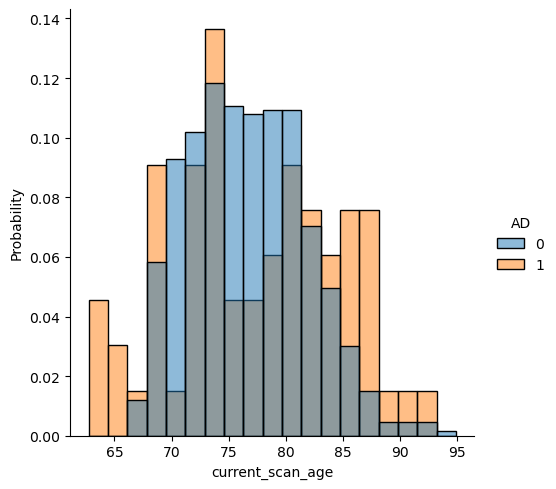

In [10]:
sns.displot(
    df,
    x="current_scan_age",
    hue="AD",
    stat="probability",
    common_norm=False,
)
plt.show()

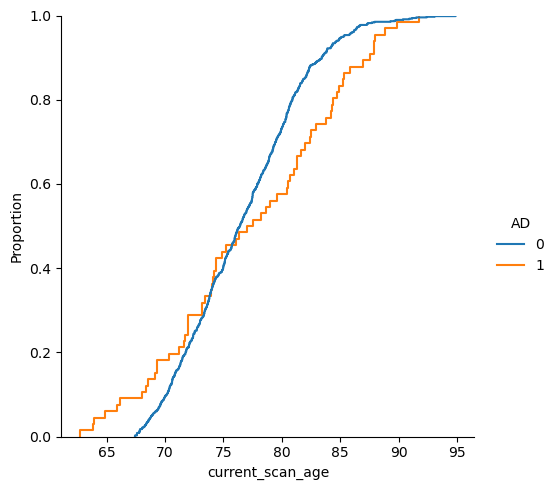

In [11]:
sns.displot(
    df,
    x="current_scan_age",
    hue="AD",
    kind="ecdf",
)
plt.show()

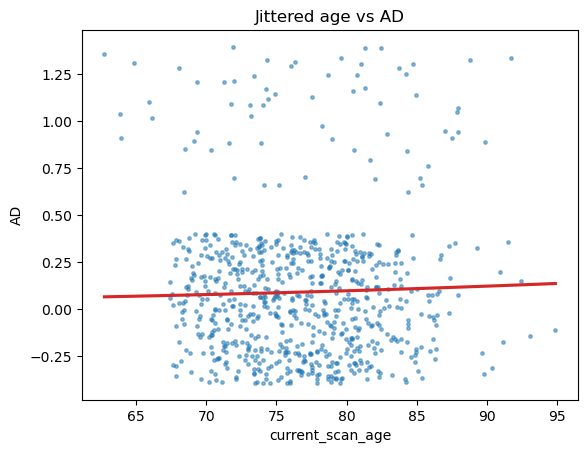

In [12]:
sns.regplot(
    df,
    x="current_scan_age", 
    y="AD",
    logistic=True,
    ci=None,
    line_kws={"color":"tab:red"}, 
    scatter_kws={"alpha": 0.5, "s":6},
    y_jitter=0.4,
)
plt.title("Jittered age vs AD")
plt.show()

### APOE allele

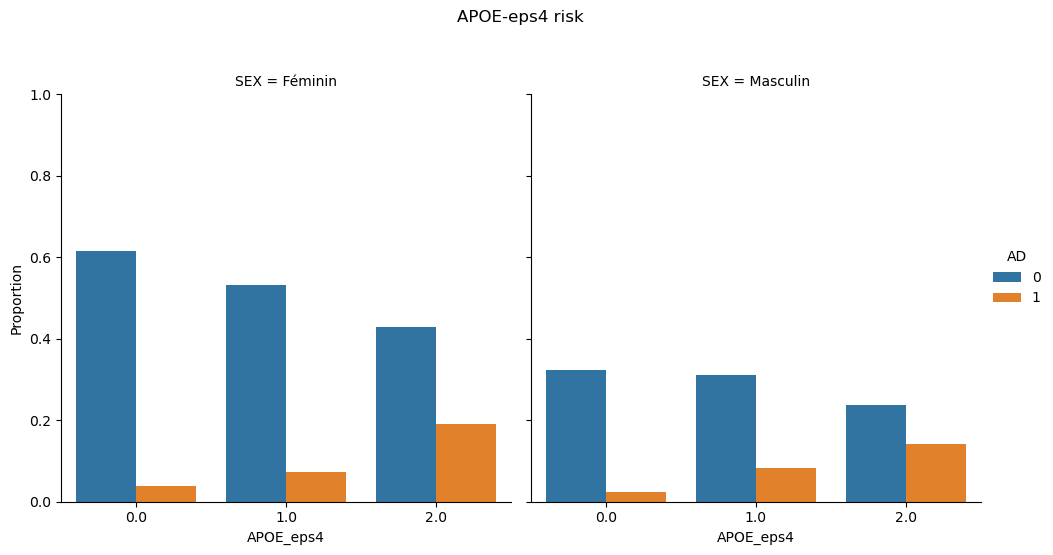

In [14]:
x, y = 'APOE_eps4', "AD"
f = (cleaned_df.groupby(x)[[y, "SEX"]]
.value_counts(normalize=True)
.rename('Proportion')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='Proportion',hue=y,kind='bar', col="SEX"))
plt.ylim(0, 1)
plt.suptitle("APOE-eps4 risk", y=1.1)
plt.show()

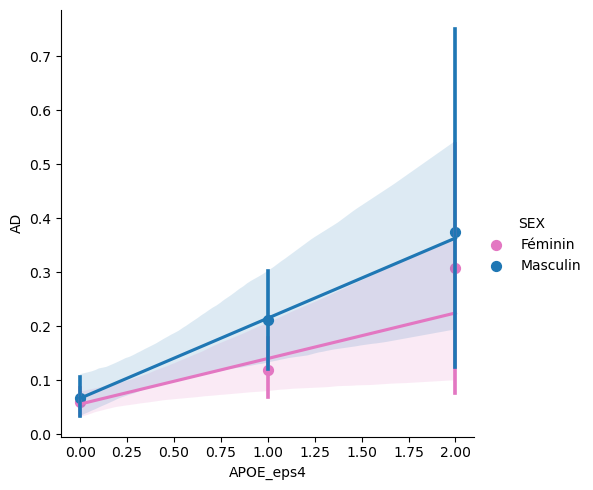

In [31]:
sns.lmplot(
    y="AD",
    x="APOE_eps4",
    data=cleaned_df,
    x_estimator=np.mean,
    #logistic=True,
    hue="SEX",
    palette=["tab:pink", "tab:blue"]
)
plt.show()

## Model fitting

In [56]:
lhs, rhs = model_matrix("ROI_20 ~ AD", df)

In [57]:
import statsmodels.api as sm

model = sm.OLS(endog=lhs, exog=rhs)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ROI_20   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.951
Date:                Tue, 27 Feb 2024   Prob (F-statistic):             0.0472
Time:                        18:50:52   Log-Likelihood:                 157.91
No. Observations:                 731   AIC:                            -311.8
Df Residuals:                     729   BIC:                            -302.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3928      0.008     51.958      0.000       0.378       0.408
AD            -0.0508      0.026     -1.988      0.047      -0.101      -0.001
==============================================================================
Omnibus:                        0.498   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.779   Jarque-Bera (JB):                0.421
Skew:                           0.056   Prob(JB):                        0.810
Kurtosis:                       3.036   Cond. No.                         3.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
def sigmoid(x):
    return np.exp(x) / (1 + np.exp(x))

def logit(p):
    return np.log(p / (1 - p))

In [ ]:
import statsmodels.formula.api as smf

model = smf.logit(
    "AD ~ APOE_eps4 + scale(current_scan_age) + SEX", cleaned_df
)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.286238
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     AD   No. Observations:                  713
Model:                          Logit   Df Residuals:                      709
Method:                           MLE   Df Model:                            3
Date:                Tue, 27 Feb 2024   Pseudo R-squ.:                 0.06220
Time:                        15:12:37   Log-Likelihood:                -204.09
converged:                       True   LL-Null:                       -217.62
Covariance Type:            nonrobust   LLR p-value:                 5.684e-06
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.8951      0.211    -13.724      0.000      -3.309      -2.482
SEX[T.Masculin]             0.3669      0.269      1.362      0.173      -0.161       0.895
APOE_eps4                   1.0307      0.209      4.933      0.000       0.621       1.440
scale(current_scan_age)     0.2096      0.129      1.627      0.104      -0.043       0.462
===========================================================================================
"""

In [ ]:
odds_ratios = pd.DataFrame(
    {
        "OR": result.params,
        "Lower CI": result.conf_int()[0],
        "Upper CI": result.conf_int()[1],
    }
)
odds_ratios = sigmoid(odds_ratios)

print(odds_ratios)

                               OR  Lower CI  Upper CI
Intercept                0.052396  0.035278  0.077155
SEX[T.Masculin]          0.590718  0.459805  0.709919
APOE_eps4                0.737055  0.650492  0.808491
scale(current_scan_age)  0.552219  0.489259  0.613549
